# Gemma‑3‑27B Baseline

Evaluates Gemma-3-27B (via LM Studio) zero-shot on a processed multilingual test split (DE, FR) from MMMLU, filtered by Q+Choices token length. Analyzes performance by subject.

## 1  Setup

In [35]:
# !pip -q install --upgrade openai datasets tqdm scikit-learn transformers huggingface_hub pandas matplotlib seaborn

In [36]:
from datasets import load_dataset, concatenate_datasets, Dataset, get_dataset_config_names, ClassLabel, Features, Value
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import openai, os, pandas as pd
import re 
from transformers import AutoTokenizer 
from huggingface_hub import login 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2  Configuration

In [ ]:
ENDPOINT   = "http://10.5.0.2:1234/v1/"   
API_KEY    = os.getenv("LMSTUDIO_API_KEY", "lm-studio") 
MODEL_NAME_LM_STUDIO = "gemma-3-27b-it"  
BATCH_SIZE = 8                  

# Data Processing Parameters
TARGET_LANGUAGES = ["DE_DE", "FR_FR"] 
MAX_Q_PLUS_CHOICES_TOKEN_LENGTH = 256 
TRAIN_PERCENT = 0.8 
VAL_PERCENT = 0.1   
TEST_PERCENT = 0.1  
SEED_SPLIT = 42     
TOKENIZER_FOR_FILTERING = "google/gemma-2-2b-it" 
HF_TOKEN = os.getenv("HF_TOKEN", None) 

client = openai.OpenAI(base_url=ENDPOINT, api_key=API_KEY)

try:
    model_ids = [m.id for m in client.models.list().data]
    print("Server models:", model_ids)
    if MODEL_NAME_LM_STUDIO not in model_ids:
        raise ValueError(f"MODEL_NAME '{MODEL_NAME_LM_STUDIO}' not served by LM Studio")
except Exception as e:
    raise SystemExit(f"Cannot reach LM Studio server → {e}")

Server models: ['gemma-3-27b-it', 'text-embedding-nomic-embed-text-v1.5']


## 3  Load, Filter, and Split MMMLU Data (DE, FR)

In [38]:
if HF_TOKEN:
    print("Using HF_TOKEN from environment variable.")
    login(token=HF_TOKEN) 
else:
    print("HF_TOKEN environment variable not set. Make sure you are logged in to Hugging Face CLI if accessing gated models.")

try:
    tokenizer_filter = AutoTokenizer.from_pretrained(TOKENIZER_FOR_FILTERING, token=HF_TOKEN if HF_TOKEN else True)
except OSError as e:
    print(f"Error loading tokenizer '{TOKENIZER_FOR_FILTERING}': {e}")
    print(f"Please ensure you have accepted the terms for '{TOKENIZER_FOR_FILTERING}' on Hugging Face and are authenticated.")
    raise

def construct_q_plus_choices_text(example):
    return f"Question: {example['Question']}\nChoices:\nA: {example['A']}\nB: {example['B']}\nC: {example['C']}\nD: {example['D']}"

def filter_by_q_plus_choices_token_length(example):
    text_to_tokenize = construct_q_plus_choices_text(example)
    return len(tokenizer_filter.tokenize(text_to_tokenize)) <= MAX_Q_PLUS_CHOICES_TOKEN_LENGTH

all_lang_datasets_filtered = []
available_configs = get_dataset_config_names("openai/mmmlu") 

actual_target_languages = []
for lang_code in TARGET_LANGUAGES:
    if lang_code in available_configs:
        actual_target_languages.append(lang_code)
    else:
        print(f"Warning: Specified target language configuration '{lang_code}' not found in available configs. Skipping.")
print(f"Processing languages: {actual_target_languages}")

original_features = None
subject_class_label_feature = None # To store the ClassLabel feature for 'Subject'

for config_name in actual_target_languages:
    print(f"\nProcessing {config_name}...")
    lang_ds = load_dataset("openai/mmmlu", config_name, split="test")
    if original_features is None: 
        original_features = lang_ds.features.copy()
        if 'language' not in original_features:
             original_features['language'] = Value('string')

    lang_ds_filtered = lang_ds.filter(filter_by_q_plus_choices_token_length, num_proc=4)
    if len(lang_ds_filtered) > 0:
        lang_ds_filtered = lang_ds_filtered.map(lambda example: {'language': config_name})
        all_lang_datasets_filtered.append(lang_ds_filtered)
    print(f"  {config_name}: {len(lang_ds)} initial -> {len(lang_ds_filtered)} after Q+Choices token filter (<= {MAX_Q_PLUS_CHOICES_TOKEN_LENGTH}).")

if not all_lang_datasets_filtered:
    if original_features:
         combined_filtered_ds = Dataset.from_dict({col_name: [] for col_name in original_features}, features=original_features)
    else: 
         combined_filtered_ds = Dataset.from_list([])
    print("Warning: No data remaining after filtering for the target languages. Proceeding with empty dataset.")
else:
    combined_filtered_ds = concatenate_datasets(all_lang_datasets_filtered).shuffle(seed=SEED_SPLIT)
print(f"\nTotal examples after filtering and combining ({', '.join(actual_target_languages)}): {len(combined_filtered_ds)}")

if len(combined_filtered_ds) > 0:
    new_features = combined_filtered_ds.features.copy()
    if 'Subject' in new_features and len(combined_filtered_ds.unique('Subject')) > 0:
        subject_names = sorted(list(combined_filtered_ds.unique('Subject')))
        new_features['Subject'] = ClassLabel(names=subject_names) 
        if 'language' not in new_features: 
            new_features['language'] = Value('string')
        try:
            combined_filtered_ds = combined_filtered_ds.cast(new_features)
            subject_class_label_feature = combined_filtered_ds.features['Subject'] # Store for later conversion
            print("Successfully casted 'Subject' column to ClassLabel for stratification.")
        except Exception as e:
            print(f"Could not cast 'Subject' to ClassLabel, stratification might fail or be inaccurate: {e}")
            subject_class_label_feature = None 
    else:
        print("Warning: 'Subject' column missing or has no unique values. Stratification by 'Subject' will be skipped.")
        subject_class_label_feature = None

current_features_for_empty_ds = combined_filtered_ds.features if len(combined_filtered_ds) > 0 else original_features
if current_features_for_empty_ds is None:
     current_features_for_empty_ds = Features({'Question': Value(dtype='string'), 'A': Value(dtype='string'), 'B': Value(dtype='string'), 'C': Value(dtype='string'), 'D': Value(dtype='string'), 'Answer': Value(dtype='string'), 'Subject': Value(dtype='string'), 'language': Value(dtype='string')})
mmmlu_ds_train_val = Dataset.from_dict({col_name: [] for col_name in current_features_for_empty_ds}, features=current_features_for_empty_ds)
mmmlu_ds_test_split = Dataset.from_dict({col_name: [] for col_name in current_features_for_empty_ds}, features=current_features_for_empty_ds)

if len(combined_filtered_ds) > 0:
    if TEST_PERCENT == 1.0:
        mmmlu_ds_test_split = combined_filtered_ds
    elif TEST_PERCENT == 0.0:
        mmmlu_ds_train_val = combined_filtered_ds 
    elif TEST_PERCENT > 0.0 and TEST_PERCENT < 1.0:
        stratify_column = "Subject" if subject_class_label_feature else None
        if stratify_column is None and 'Subject' in combined_filtered_ds.features:
             print("Warning: Attempting to split without 'Subject' stratification as it's not ClassLabel or casting failed.")
        temp_split = combined_filtered_ds.train_test_split(test_size=TEST_PERCENT, shuffle=True, seed=SEED_SPLIT, stratify_by_column=stratify_column)
        mmmlu_ds_train_val = temp_split['train']
        mmmlu_ds_test_split = temp_split['test']
else:
    print("Combined filtered dataset is empty, cannot create train/val/test splits.")

print(f"Size of data for potential training/validation (for finetunes.ipynb): {len(mmmlu_ds_train_val)}")
print(f"Final test samples for Gemma-27B evaluation: {len(mmmlu_ds_test_split)}")
mmmlu_ds = mmmlu_ds_test_split

HF_TOKEN environment variable not set. Make sure you are logged in to Hugging Face CLI if accessing gated models.
Processing languages: ['DE_DE', 'FR_FR']

Processing DE_DE...
  DE_DE: 14042 initial -> 12170 after Q+Choices token filter (<= 256).

Processing FR_FR...
  FR_FR: 14042 initial -> 12043 after Q+Choices token filter (<= 256).

Total examples after filtering and combining (DE_DE, FR_FR): 24213
Successfully casted 'Subject' column to ClassLabel for stratification.
Size of data for potential training/validation (for finetunes.ipynb): 21791
Final test samples for Gemma-27B evaluation: 2422


## 4  Prompt Design

In [39]:
sys_prompt = (
    "You are a multiple-choice question solver. For each question, provide only the single capital letter "
    "(A, B, C, or D) corresponding to the correct answer. "
    "If there are multiple questions, list the letters one per line, or as a single string without spaces or punctuation (e.g., ABCD)."
)

## 5  Batched Inference Helper

In [40]:
def infer_batch(batch_dataset):
    if not batch_dataset or len(batch_dataset) == 0:
        return [] 

    q_blocks = []
    for idx, row_example in enumerate(batch_dataset, 1):
        prompt_text = construct_q_plus_choices_text(row_example) 
        q_blocks.append(f"Q{idx}: {prompt_text}\nAnswer:") 
    user_prompt = "\n\n".join(q_blocks)

    response = client.chat.completions.create(
        model=MODEL_NAME_LM_STUDIO,
        messages=[
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.0,
        max_tokens=len(batch_dataset) * 2 + 10, 
    )
    raw_response = response.choices[0].message.content.strip()
    parsed_letters = []
    lines = [line.strip().upper() for line in raw_response.splitlines() if line.strip()]
    for line in lines:
        match = re.search(r"^[ABCD](?!\w)", line) 
        if match:
            parsed_letters.append(match.group(0))
        if len(parsed_letters) == len(batch_dataset):
            break
    if len(parsed_letters) < len(batch_dataset):
        cleaned_response = re.sub(r'[^ABCD]', '', raw_response.upper())
        current_parsed_letters = list(cleaned_response)
        if not (parsed_letters and (not current_parsed_letters or len(current_parsed_letters) < len(parsed_letters))):
            parsed_letters = current_parsed_letters
    
    final_letters = parsed_letters[:len(batch_dataset)]
    if len(final_letters) < len(batch_dataset):
        final_letters.extend(["?"] * (len(batch_dataset) - len(final_letters)))
    return final_letters

## 6  Evaluation Loop

In [41]:
true_labels, pred_labels, subjects_for_analysis = [], [], []
if len(mmmlu_ds) > 0:
    for i in tqdm(range(0, len(mmmlu_ds), BATCH_SIZE)):
        batch_indices = range(i, min(i + BATCH_SIZE, len(mmmlu_ds)))
        batch = mmmlu_ds.select(batch_indices)
        if len(batch) == 0: continue 
        preds = infer_batch(batch)
        pred_labels.extend(preds)
        true_labels.extend([row['Answer'].strip().upper()[:1] for row in batch])
        # Store subject names for analysis
        if subject_class_label_feature: # Check if 'Subject' was successfully cast to ClassLabel
            subjects_for_analysis.extend([subject_class_label_feature.int2str(row['Subject']) for row in batch])
        else: # Fallback if cast failed or 'Subject' is not ClassLabel
            subjects_for_analysis.extend([str(row['Subject']) for row in batch])
else:
    print("No samples in mmmlu_ds for evaluation. Check data processing steps.")

100%|██████████| 303/303 [10:20<00:00,  2.05s/it]


## 7  Results and Per-Subject Analysis

Overall Accuracy on 2422 questions: 0.6759
Overall Confusion matrix (A/B/C/D rows vs cols):
 [[390  64  43  37]
 [ 88 406  64  47]
 [ 88  76 432  31]
 [ 99  61  75 409]]

Accuracy per Subject (sorted lowest to highest):
  machine_learning (n=22): 0.3636
  professional_law (n=77): 0.3896
  college_mathematics (n=20): 0.4000
  moral_scenarios (n=179): 0.4078
  abstract_algebra (n=20): 0.4500
  econometrics (n=23): 0.4783
  anatomy (n=27): 0.4815
  business_ethics (n=20): 0.5000
  public_relations (n=22): 0.5000
  global_facts (n=20): 0.5000
  high_school_statistics (n=40): 0.5250
  high_school_physics (n=30): 0.5333
  formal_logic (n=24): 0.5417
  virology (n=33): 0.5455
  high_school_chemistry (n=40): 0.5500
  college_physics (n=20): 0.5500
  high_school_mathematics (n=54): 0.5556
  professional_accounting (n=55): 0.5636
  college_chemistry (n=20): 0.6000
  college_computer_science (n=18): 0.6111
  human_sexuality (n=26): 0.6154
  clinical_knowledge (n=53): 0.6226
  professional_psychol

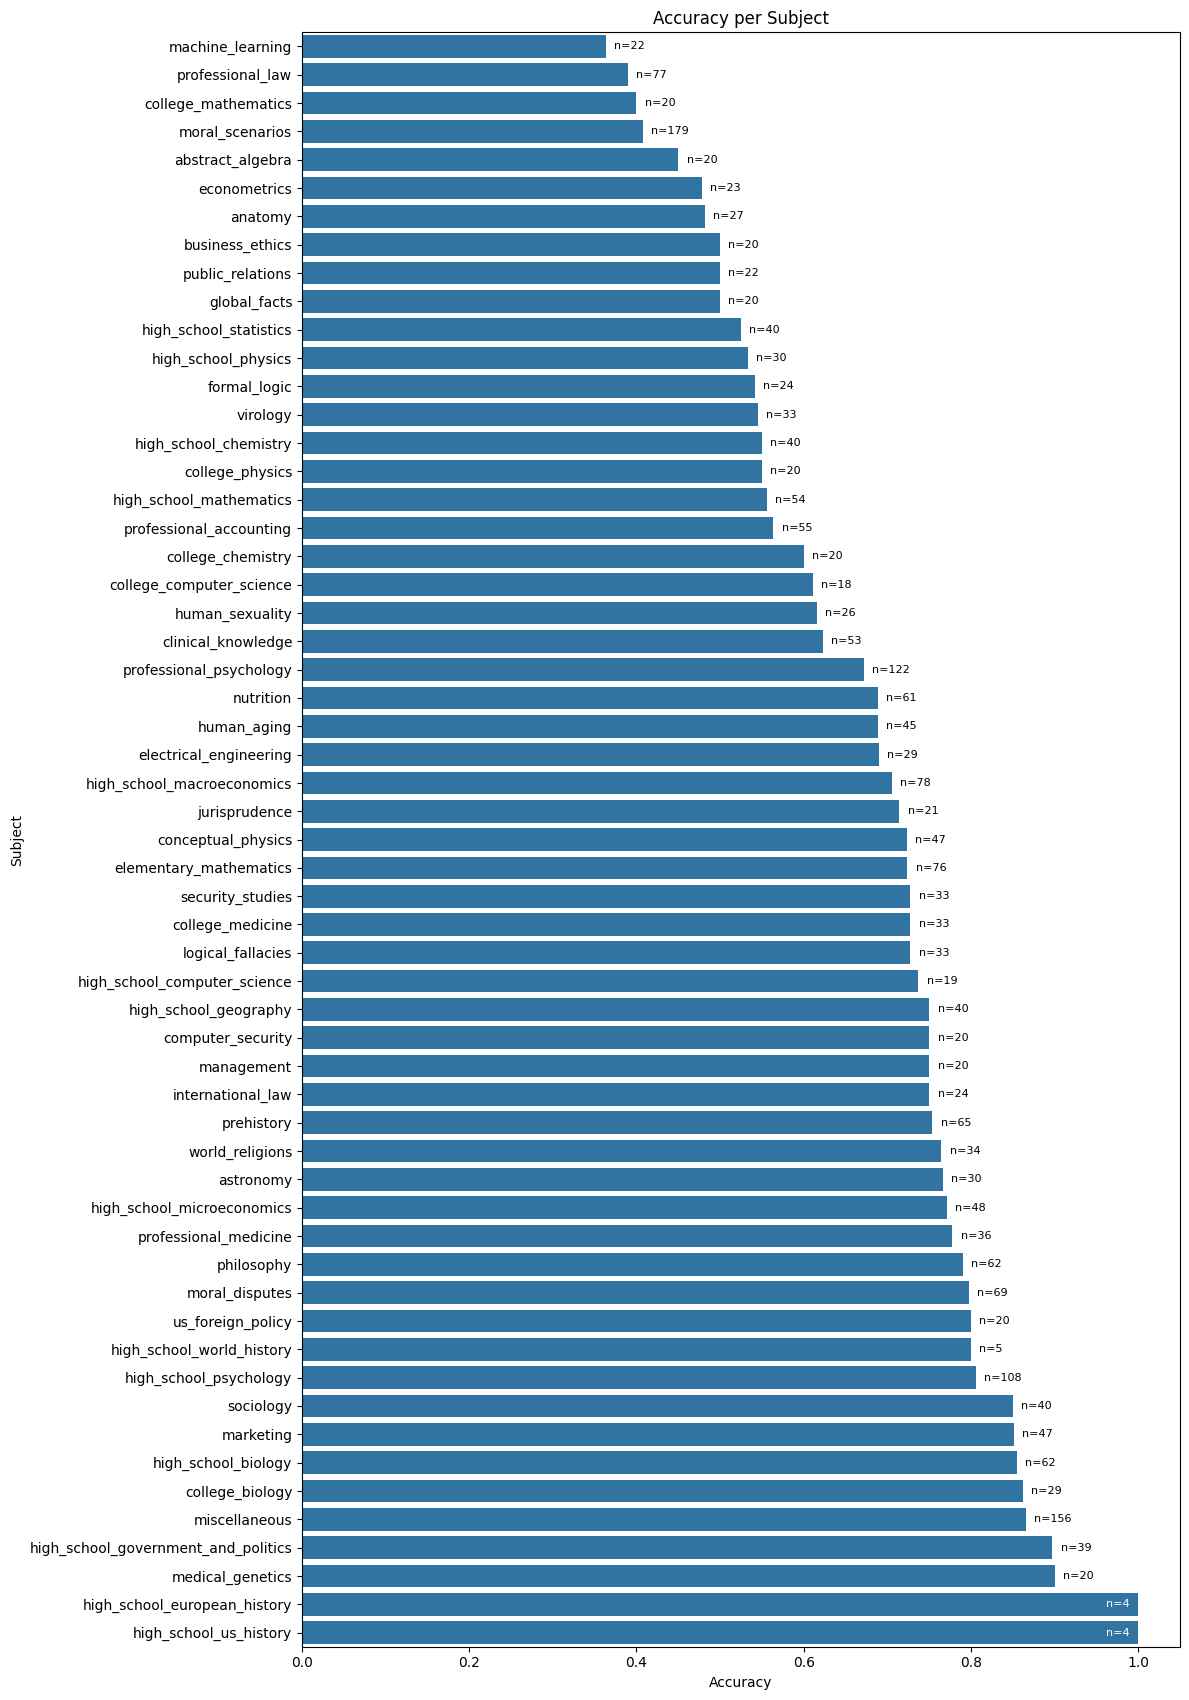

In [42]:
if len(true_labels) > 0:
    overall_acc = accuracy_score(true_labels, pred_labels)
    print(f"Overall Accuracy on {len(mmmlu_ds)} questions: {overall_acc:.4f}")
    print("Overall Confusion matrix (A/B/C/D rows vs cols):\n", confusion_matrix(true_labels, pred_labels, labels=list("ABCD")))

    results_df = pd.DataFrame({
        'Subject': subjects_for_analysis,
        'TrueLabel': true_labels,
        'PredictedLabel': pred_labels
    })
    results_df['Correct'] = (results_df['TrueLabel'] == results_df['PredictedLabel'])
    
    subject_accuracy = results_df.groupby('Subject')['Correct'].mean().sort_values()
    subject_counts = results_df['Subject'].value_counts().reindex(subject_accuracy.index, fill_value=0)
    
    print("\nAccuracy per Subject (sorted lowest to highest):")
    for subject_name_val, acc_val in subject_accuracy.items(): 
        print(f"  {subject_name_val} (n={subject_counts.get(subject_name_val, 0)}): {acc_val:.4f}")
    
    if not subject_accuracy.empty:
        worst_subject = subject_accuracy.index[0]
        worst_acc_val = subject_accuracy.iloc[0]
        print(f"\nWorst performing subject: {worst_subject} with accuracy {worst_acc_val:.4f} (n={subject_counts.get(worst_subject,0)})")

        best_subject = subject_accuracy.index[-1]
        best_acc_val = subject_accuracy.iloc[-1]
        print(f"Best performing subject: {best_subject} with accuracy {best_acc_val:.4f} (n={subject_counts.get(best_subject,0)})")

        plt.figure(figsize=(12, max(8, len(subject_accuracy) * 0.3)))
        ax = sns.barplot(x=subject_accuracy.values, y=subject_accuracy.index, orient='h')
        plt.xlabel('Accuracy')
        plt.ylabel('Subject')
        plt.title('Accuracy per Subject')
        plt.xlim(0, 1.05) 

        for i, bar in enumerate(ax.patches):
            accuracy_val = bar.get_width()
            current_subject_name = subject_accuracy.index[i]
            count = subject_counts.get(current_subject_name, 0)
            
            text_x_position = accuracy_val + 0.01 
            horizontal_alignment = 'left'
            color = 'black'

            if accuracy_val > 0.9: 
                text_x_position = accuracy_val - 0.01
                horizontal_alignment = 'right'
                color = 'white' 
            elif accuracy_val < 0.15 and len(f'n={count}') > 2: 
                 text_x_position = accuracy_val + 0.01 
            
            ax.text(text_x_position, 
                    bar.get_y() + bar.get_height() / 2, 
                    f'n={count}', 
                    ha=horizontal_alignment, 
                    va='center',
                    fontsize=8,
                    color=color)
        plt.tight_layout()
        plt.show()
else:
    print("No results to display as no samples were evaluated.")